In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime

In [2]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

# **Landsat-8 WOFS Product Creation**

### Config

Import required DC utils

In [32]:
import datacube
# DC utilities
from datacube_utilities.dc_display_map import display_map
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.import_export import export_xarray_to_netcdf
from datacube_utilities.createAOI import create_lat_lon

Define aoi via wkt polygon (could be subbed or shapefile)

In [5]:
#aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
#testarea
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
aoi_wkt = "POLYGON((177.34673877691375 -17.587272740290974,177.6955546948825 -17.587272740290974,177.6955546948825 -17.800529711996226,177.34673877691375 -17.800529711996226,177.34673877691375 -17.587272740290974))"
#whole country
#aoi_wkt = "POLYGON((177.21496582032 -17.254028320312, 178.76403808594 -17.259521484375, 178.76953125001 -18.286743164062, 177.19848632813 -18.286743164062, 177.21496582032 -17.254028320312))"
#aoi_wkt = "POLYGON((178.24905395508 -18.036804199219, 178.51547241212 -18.038177490235, 178.51547241212 -18.220825195313, 178.25454711915 -18.220825195313, 178.24905395508 -18.036804199219))"
#aoi_wkt = "POLYGON((178.11035156251 -17.841796875, 178.83544921876 -17.830810546875, 178.83544921876 -18.297729492187, 178.10485839844 -18.30322265625, 178.11035156251 -17.841796875))"
#aoi_wkt = "POLYGON ((177.4134063720703 -17.884005713834192, 177.77938842773435 -17.884005713834192, 177.77938842773435 -17.616537468641294, 177.4134063720703 -17.616537468641294, 177.4134063720703 -17.884005713834192))"
aoi_wkt = "POLYGON((177.34096527101 -17.746353149414, 177.43160247804 -17.744293212891, 177.4364089966 -17.834930419922, 177.34165191652 -17.833557128906, 177.34096527101 -17.746353149414))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')

In [ ]:
#set baseline start and end of period
start_date = '2015-3-1'
end_date = '2015-9-1'

res = (30)

In [34]:
dc = datacube.Datacube(app="water permamency")

In [30]:
lat_extents, lon_extents = create_lat_lon(aoi_wkt)

In [33]:
display_map(latitude = lat_extents, longitude = lon_extents)

### Load Data

Generic query specs

In [13]:
query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:32760",
                time = (datetime(2018,1,1), datetime(2018,6,1)),
                resolution = (30,30))


Dataset-specifics

In [14]:
scenes = dc.load(product="ls8_water_classification",
               group_by='solar_day',
               measurements = ["water"],
               **query)

We've been testing removal of no-data value to nan. This doesn't seem to work though as outputs from wofs over nan areas is 0, which skews the total no. observations.

In [15]:
#scenes = scenes.where(scenes != -9999.) 
scenespd = pd.DataFrame(scenes)
print(scenespd.head())

       0
0  water


In [16]:
print(scenes)

<xarray.Dataset>
Dimensions:  (time: 21, x: 339, y: 336)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T22:12:57 ... 2018-05-27T21:59:17
  * y        (y) float64 8.028e+06 8.028e+06 8.028e+06 ... 8.038e+06 8.038e+06
  * x        (x) float64 5.361e+05 5.361e+05 5.362e+05 ... 5.462e+05 5.463e+05
Data variables:
    water    (time, y, x) int16 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999
Attributes:
    crs:      EPSG:32760


Check loaded

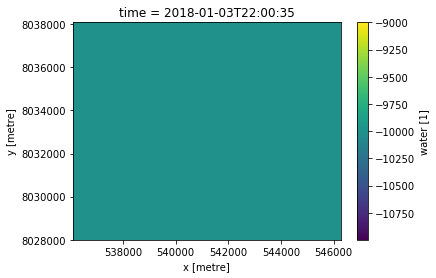

In [17]:
scenes.isel(time = 1).water.plot();

Create + apply 'cleansky' mask

In [18]:
#clearsky_masks = landsat_qa_clean_mask(scenes, 'LANDSAT_8')
clearsky_scenes = scenes.where(scenes != -9999)

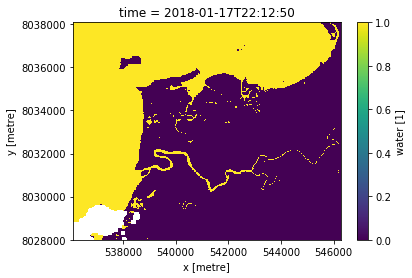

In [19]:
clearsky_scenes.isel(time = 2).water.plot();

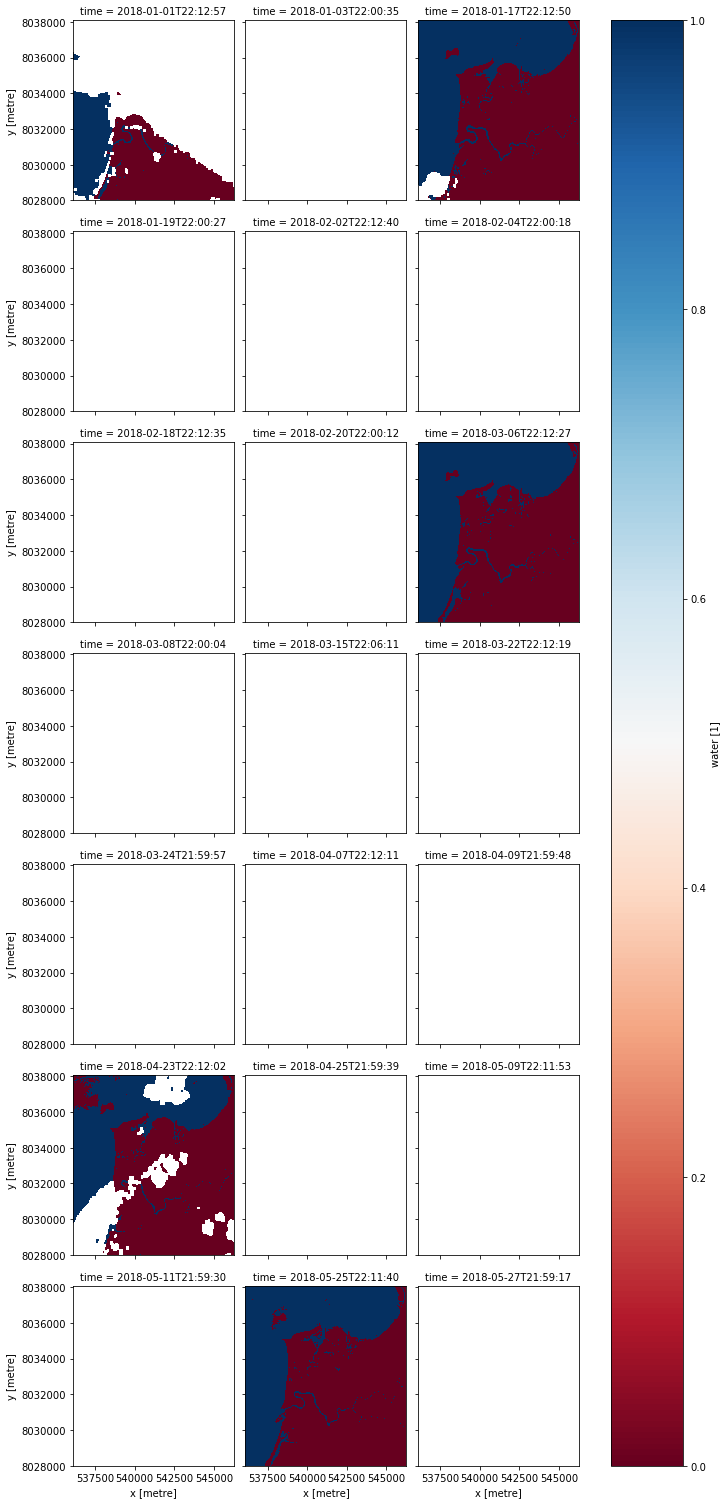

In [20]:
clearsky_scenes.water.plot(col='time', cmap='RdBu', col_wrap=3, vmin=0, vmax=1)

In [21]:
clearsky_scenes

<xarray.Dataset>
Dimensions:  (time: 21, x: 339, y: 336)
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T22:12:57 ... 2018-05-27T21:59:17
  * y        (y) float64 8.028e+06 8.028e+06 8.028e+06 ... 8.038e+06 8.038e+06
  * x        (x) float64 5.361e+05 5.361e+05 5.362e+05 ... 5.462e+05 5.463e+05
Data variables:
    water    (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:32760

Apply wofs classification

In [22]:
#water_classes = wofs_classify(scenes, clean_mask=clearsky_masks.values , no_data = np.nan , x_coord='x', y_coord = "y")

In [23]:
#water_classes.isel(time = 0).wofs.plot();

Visualise wofs summary product

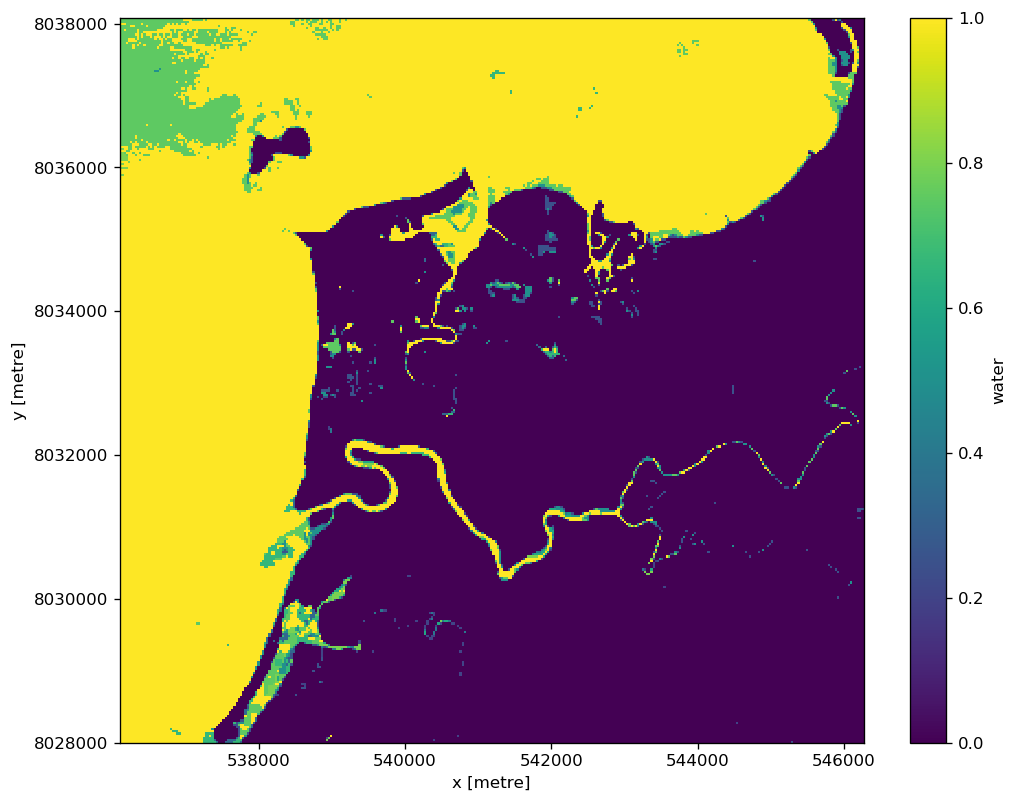

In [24]:
plt.figure(figsize = (10,8), dpi=120)
clearsky_scenes.water.mean(dim = 'time').plot();

### Export to file within shared storage

Define output path

In [25]:
# Ensure the output directory exists before writing to it.
!mkdir -p /home/shared/geo_demos/wofs_testers
output_file_name  =  "/home/shared/geo_demos/wofs_testers/l8_indiv.nc"

Correct attributes and add to wofs xarray (for some reason we have 'dc_partual_load' as true...)

In [26]:
scenes.attrs

OrderedDict([('crs', CRS('EPSG:32760'))])

In [27]:
# at = scenes.attrs
# del at['dc_partial_load']
# at

In [28]:
dataset_to_output =  water_classes.assign_attrs(scenes.attrs)

NameError: name 'water_classes' is not defined

In [ ]:
dataset_to_output.attrs

Export

In [21]:
export_xarray_to_netcdf(dataset_to_output, output_file_name)
#export_xarray_to_netcdf